In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from msfm import grid_pipeline
from msfm.utils import logger, input_output, analysis
# from msfm.utils import input_output, analysis, maps, logger

In [11]:
grid_dset = grid_pipeline.get_grid_dset(
    tfr_pattern="/cluster/scratch/athomsen/CosmoGrid/debug/v3/grid/DESy3_grid_???.tfrecord",
    local_batch_size=1,
    n_readers=1,
    n_prefetch=1,
)

23-04-28 11:35:48 grid_pipelin INF   Starting to generate the grid data set for i_noise = 0 
23-04-28 11:35:48  analysis.py INF   Loaded the config 
23-04-28 11:35:48  analysis.py INF   Loaded the config 
/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5
23-04-28 11:35:48  analysis.py INF   Loaded the pixel file 
23-04-28 11:35:48  analysis.py INF   Loaded the config 
/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5
23-04-28 11:35:49  analysis.py INF   Loaded the pixel file 
23-04-28 11:35:49 grid_pipelin INF   Batching into 1 elements locally 
(TensorSpec(shape=(None, 475136, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 475136, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 475136, 6), dtype=tf.int16, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, n

In [12]:
for data_vectors, cosmo, index in grid_dset.take(1):
    print(data_vectors.shape)
    print(cosmo.shape)
    print(index)

(1, 475136, 10)
(1, 10)
(<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)


In [15]:
data_vec_pix, _, _, _ = analysis.load_pixel_file()
n_side = 512
n_pix = hp.nside2npix(n_side)

23-04-28 11:38:13  analysis.py INF   Loaded the config 
/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5
23-04-28 11:38:13  analysis.py INF   Loaded the pixel file 


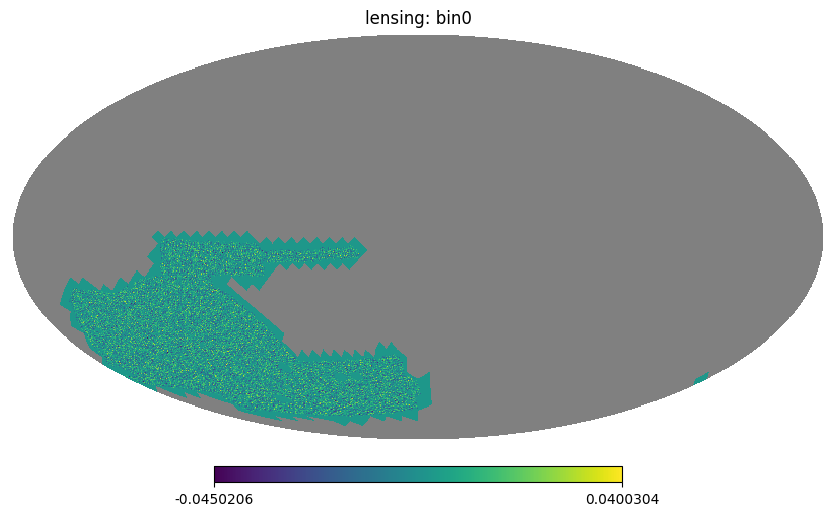

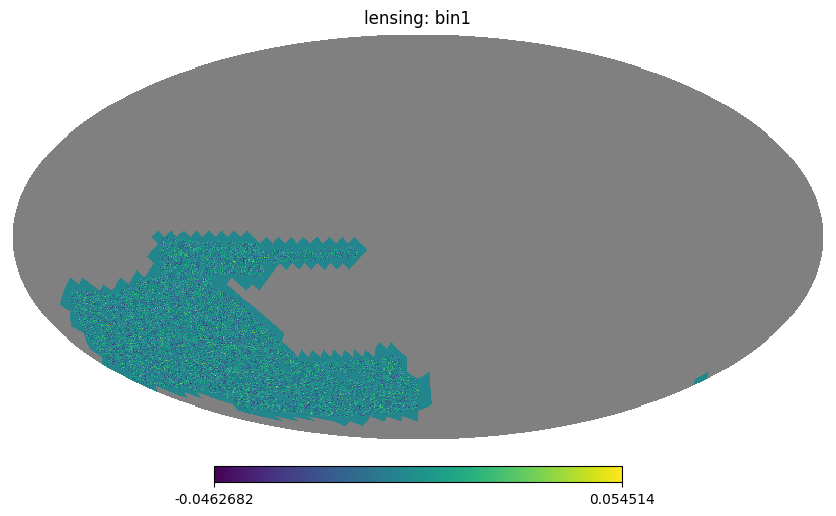

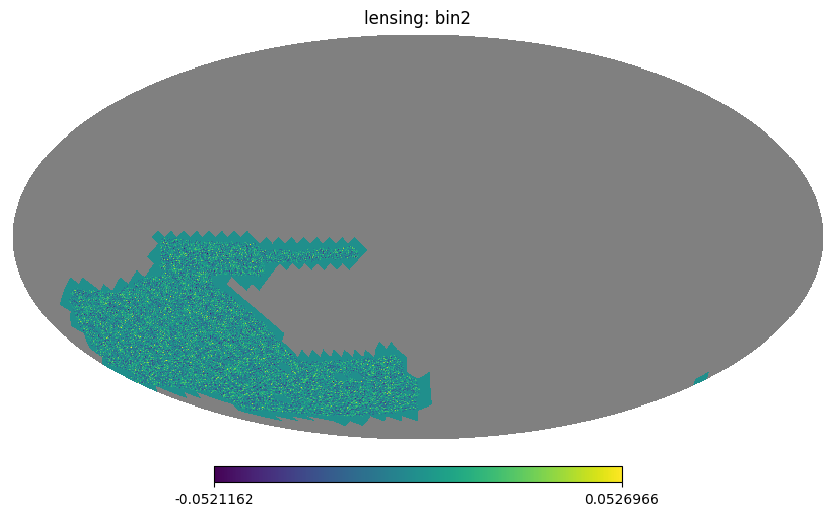

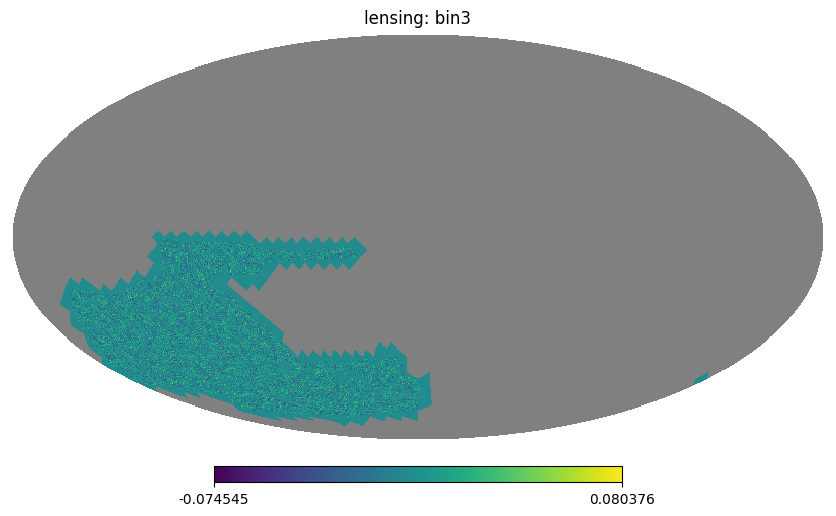

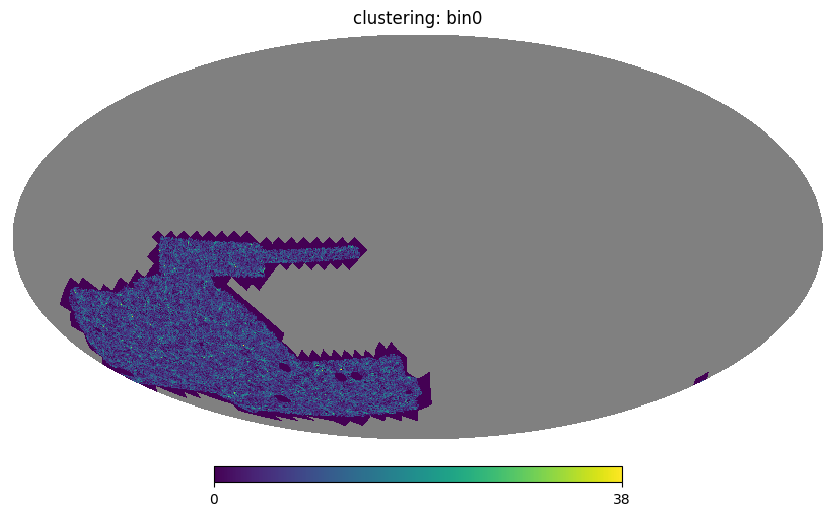

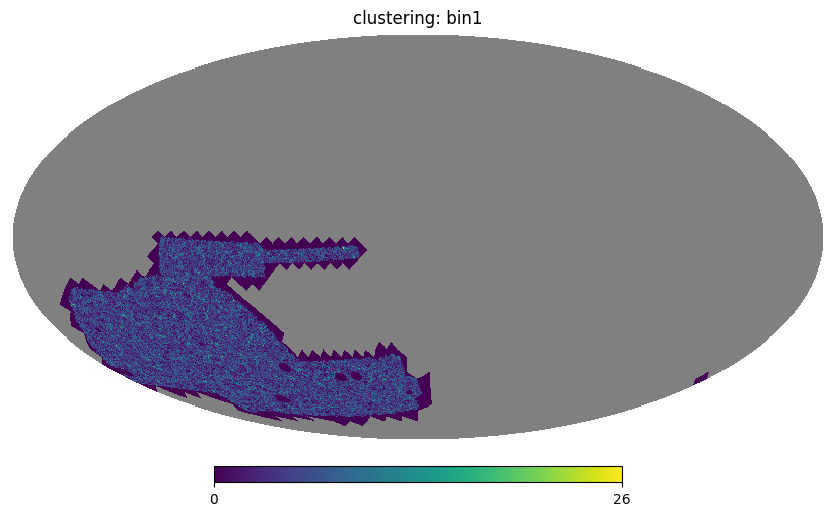

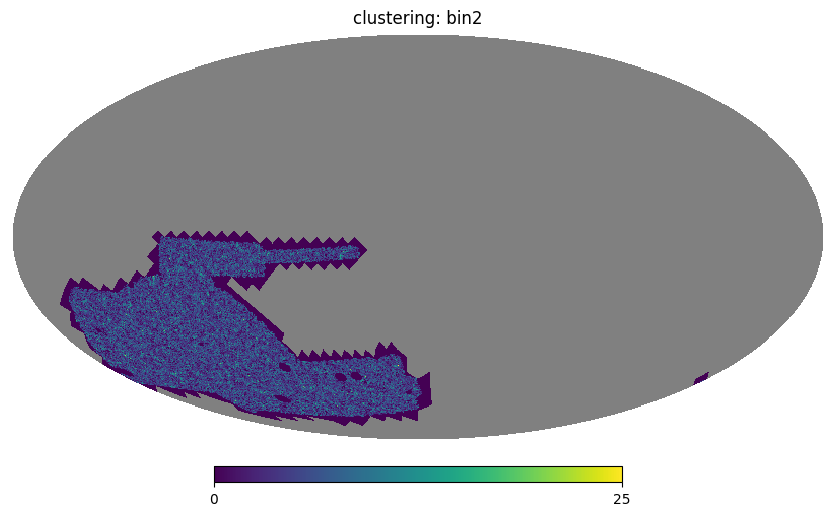

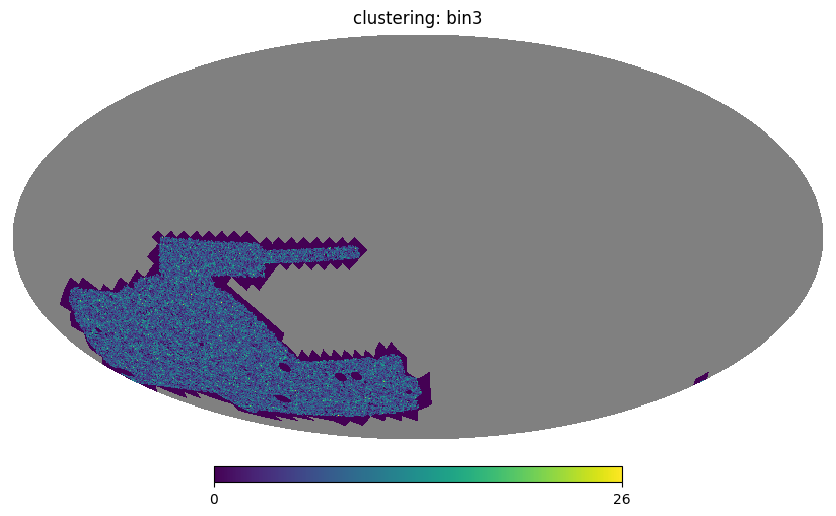

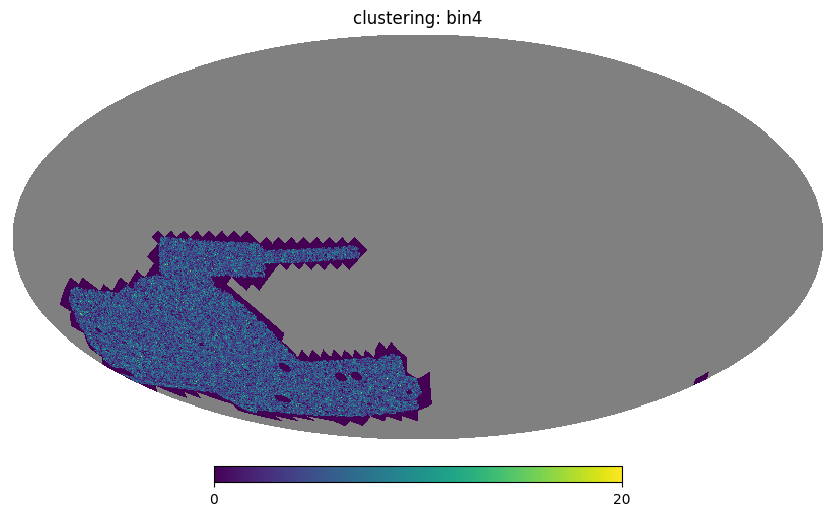

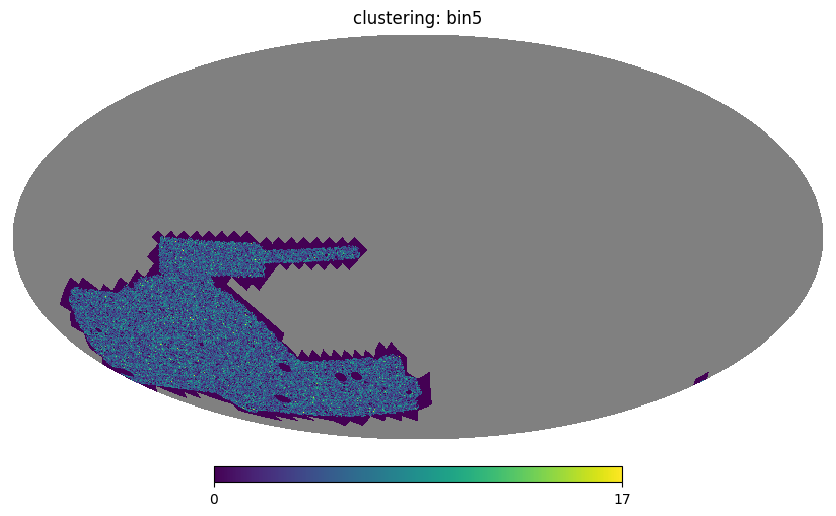

In [16]:
# loop over the tomographic bin/map type
for i in range(10):
    if i < 4:
        map_type = "lensing"
        i_tomo = i
    else:
        map_type = "clustering"
        i_tomo = i - 4
        
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = data_vectors[0,:,i]
    hp.mollview(hp_map, nest=True, title=f"{map_type}: bin{i_tomo}")    

In [31]:
LOGGER = logger.get_logger(".")

tfr_pattern = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v2/DESy3_grid_???.tfrecord"

# for metacal
n_z_bins = 4
# corresponds to one cosmology as there are 4 sims per cosmology and 4 patches per full sky map
batch_size = 32

# these are not optimized for performance
examples_shuffle_buffer = 10
n_readers = 1
n_prefetch = 3
n_batches = 7

In [25]:
dset = grid_pipeline.get_grid_dset(tfr_pattern, batch_size, n_readers=n_readers, n_prefetch=n_prefetch)

23-03-07 14:09:41 grid_pipelin INF   Starting to generate the grid data set for i_noise = 0 
23-03-07 14:09:41  analysis.py INF   Loaded the config 
23-03-07 14:09:41  analysis.py INF   Loaded the pixel file 
23-03-07 14:09:41  analysis.py INF   Loaded the config 
23-03-07 14:09:41  analysis.py INF   Loaded the pixel file 
23-03-07 14:09:42  analysis.py INF   Loaded the config 
23-03-07 14:09:42  analysis.py INF   Loaded the config 
23-03-07 14:09:42 grid_pipelin WAR   Tracing dset_add_bias 
23-03-07 14:09:42 grid_pipelin WAR   Tracing dset_add_noise 
23-03-07 14:09:42 grid_pipelin INF   Batching into 32 elements locally 
23-03-07 14:09:42 grid_pipelin INF   Successfully generated the grid set with element_spec (TensorSpec(shape=(None, 463872, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))) for i_noise = 0 


In [48]:
results = []
for data_vectors, cosmo, index in dset.take(n_batches):
    results.append(index[0])
    
temp = tf.concat(results, axis=0)
print(temp.shape)

(224,)


In [49]:
temp = tf.split(temp, batch_size * n_batches // 16, axis=0)
temp = tf.stack(temp, axis=0)
print(temp.shape)

(14, 16)


In [34]:
32*7//16

14

In [23]:
for i in range(5):
    print(temp[i,:,0])

tf.Tensor([73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73. 73.], shape=(16,), dtype=float32)
tf.Tensor(
[68.5 68.5 68.5 68.5 68.5 68.5 68.5 68.5 68.5 68.5 68.5 68.5 68.5 68.5
 68.5 68.5], shape=(16,), dtype=float32)
tf.Tensor(
[77.5 77.5 77.5 77.5 77.5 77.5 77.5 77.5 77.5 77.5 77.5 77.5 77.5 77.5
 77.5 77.5], shape=(16,), dtype=float32)
tf.Tensor(
[66.25 66.25 66.25 66.25 66.25 66.25 66.25 66.25 66.25 66.25 66.25 66.25
 66.25 66.25 66.25 66.25], shape=(16,), dtype=float32)
tf.Tensor(
[70.75 70.75 70.75 70.75 70.75 70.75 70.75 70.75 70.75 70.75 70.75 70.75
 70.75 70.75 70.75 70.75], shape=(16,), dtype=float32)


In [45]:
i = 0
for data_vectors, cosmo, index in dset.take(n_batches):
    x = data_vectors

In [47]:
y = x.numpy()

print(y.nbytes/32)

7421952.0


In [6]:
i = 0
for x in dset:
    print(i)
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [5]:
dset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=-2>

In [5]:
for kg, cosmo, index in dset.take(1):
    print(kg.shape, cosmo.shape, len(index))

(16, 463872, 4) (16, 7) 2


In [6]:
LOGGER.timer.start("grid")

counter = 0
for kg, cosmo, index in dset:
    counter += 1
    if counter % 100 == 0:
        print(f"step {counter} after {LOGGER.timer.elapsed('grid')}")
        
print(counter)

step 100 after 0:00:15.63
step 200 after 0:00:29.71
step 300 after 0:00:51.49
step 400 after 0:01:13.55
step 500 after 0:01:36.41
step 600 after 0:01:57.91
step 700 after 0:02:19.26
step 800 after 0:02:41.13
step 900 after 0:03:04.53
step 1000 after 0:03:26.21
step 1100 after 0:03:48.64
step 1200 after 0:04:09.38
step 1300 after 0:04:31.10
step 1400 after 0:04:54.36
step 1500 after 0:05:15.94
step 1600 after 0:05:38.76
step 1700 after 0:06:00.49
step 1800 after 0:06:23.93
step 1900 after 0:06:46.23
step 2000 after 0:07:08.65
step 2100 after 0:07:30.47
step 2200 after 0:07:53.09
step 2300 after 0:08:16.54
step 2400 after 0:08:38.91
step 2500 after 0:09:01.08
2500


# plotting

In [7]:
data_vec_pix, _, _, tomo_patches_pix, tomo_corresponding_pix = survey.load_pixel_file(conf, repo_dir)
n_pix = conf["analysis"]["n_pix"]

23-02-20 13:56:17    survey.py INF   Loaded pixel file 


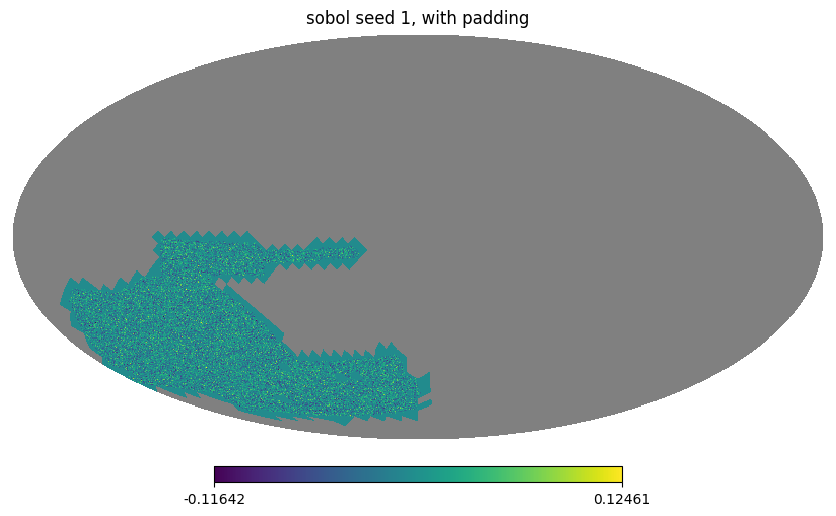

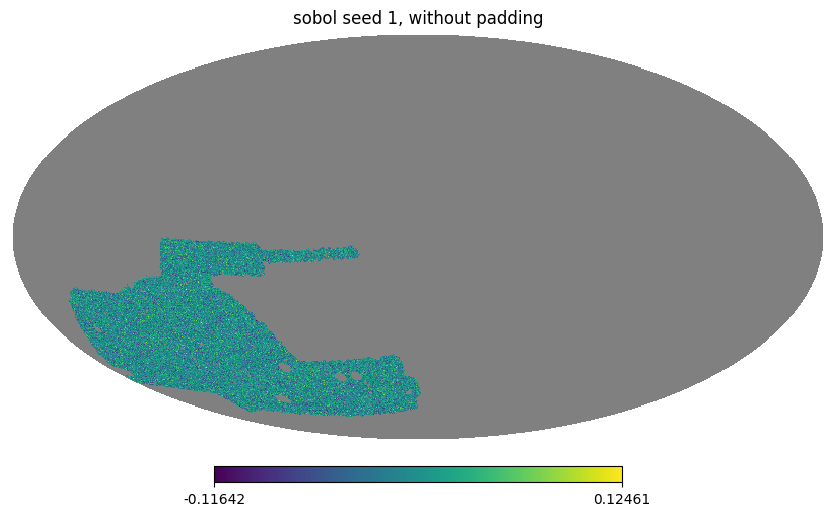

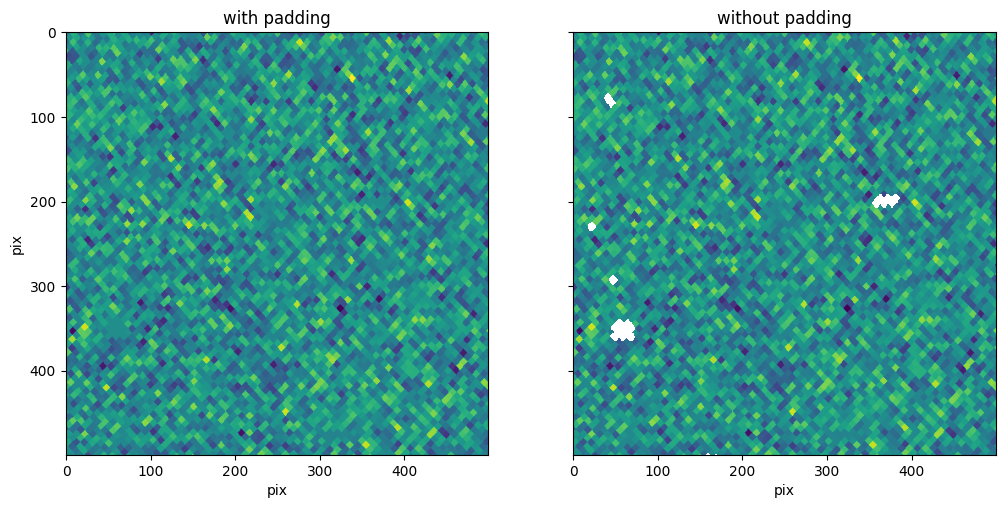

In [8]:
# map selection
i_tomo = 0
i_batch = 0

# gnomview params
square_pix = 500
reso = 1

for kg, cosmo, index in dset.take(1):
    # with padding
    padded_kg = kg.numpy()[i_batch,:,i_tomo]
    
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = padded_kg
    hp.mollview(hp_map, nest=True, title=f"sobol seed {index[0][i_batch]}, with padding")
    padded_gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)
    
    # without padding
    hp_map = maps.data_vec_to_map(padded_kg, n_pix, tomo_corresponding_pix[i_tomo], tomo_patches_pix[i_tomo][0])
    
    hp_map[hp_map == 0] = hp.UNSEEN
    hp.mollview(hp_map, nest=False, title=f"sobol seed {index[0][i_batch]}, without padding")
    non_padded_gnom = hp.gnomview(hp_map, nest=False, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)

    # combined gnomview plot, these should be identical apart from the padding
    fig, ax = plt.subplots(figsize=(12,8), ncols=2, sharex=True, sharey=True)
    ax[0].imshow(padded_gnom)
    ax[0].set(title="with padding", xlabel='pix', ylabel='pix')
    ax[1].imshow(non_padded_gnom)
    ax[1].set(title="without padding", xlabel='pix')
    
    